<a href="https://www.kaggle.com/code/tikendraw/customer-segmentation-and-visualizing-clusters?scriptVersionId=146654045" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Customer Segmentation and Analysis
Steps to solve the problem :
Visualization code is copied from this [notebook](https://www.kaggle.com/code/kushal1996/customer-segmentation-k-means-analysis) credit to the owner. in the same dataset. 
* Exploration of data. 
* Data Visualization.
* Check all Hyperparameters for better clustering and good Scores
* Clustering using K-Means and other Clustering Algorithms.
* 2D and 3D Plot of Clusters.
* Silhouette Plot

In [1]:
 
import os
import math
import random
import itertools
import warnings
from itertools import product

import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import (
    DBSCAN,
    AffinityPropagation,
    MeanShift,
    MiniBatchKMeans,
    KMeans,
    AgglomerativeClustering,
    estimate_bandwidth,
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn import cluster, mixture, metrics
import sklearn

warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

random_seed = 69

np.random.seed(random_seed)
random.seed(random_seed)


In [2]:
!ls ../input/customer-segmentation-tutorial-in-python

Mall_Customers.csv


# Data

In [3]:
df = pd.read_csv('../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [6]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [7]:
df.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [8]:
df['Gender2'] = df['Gender'].map({'Female' : 0 , 'Male' : 1})

In [9]:
df2 = df.drop(['CustomerID' , 'Gender'] , axis = 1)

# Data Visualization

In [10]:
plt.style.use('fivethirtyeight')

## Histogram

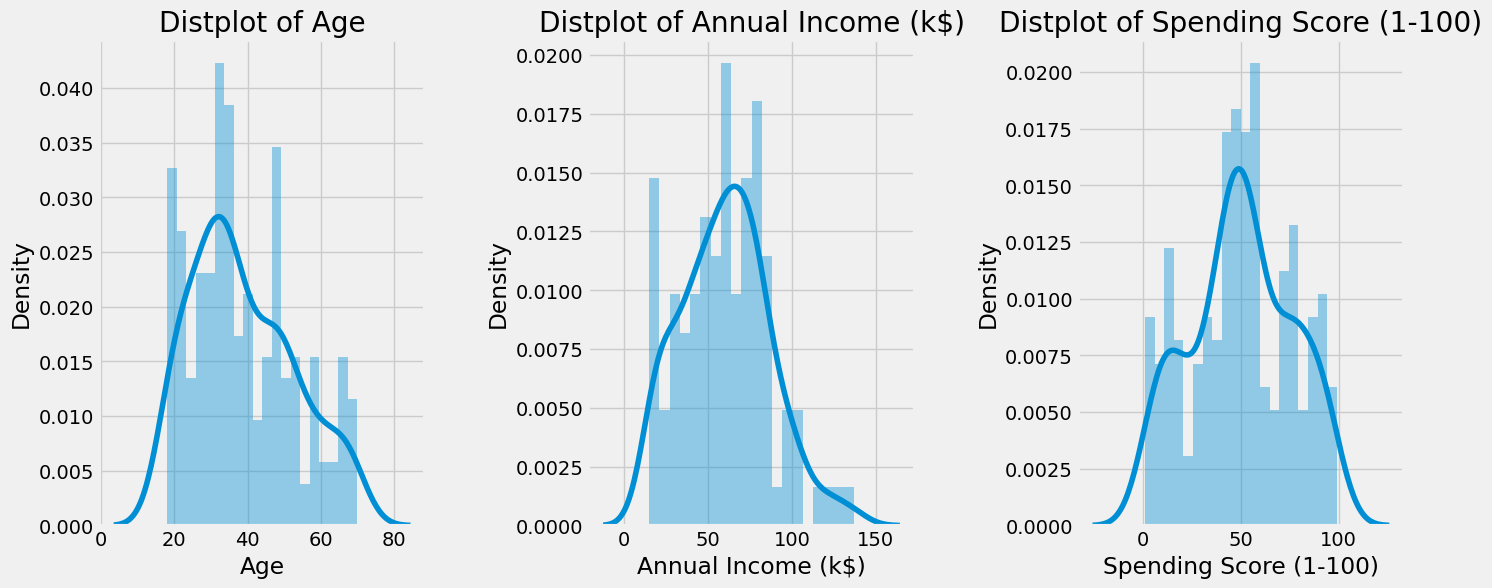

In [11]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title(f'Distplot of {x}')
plt.show()

## Count Plot of Gender

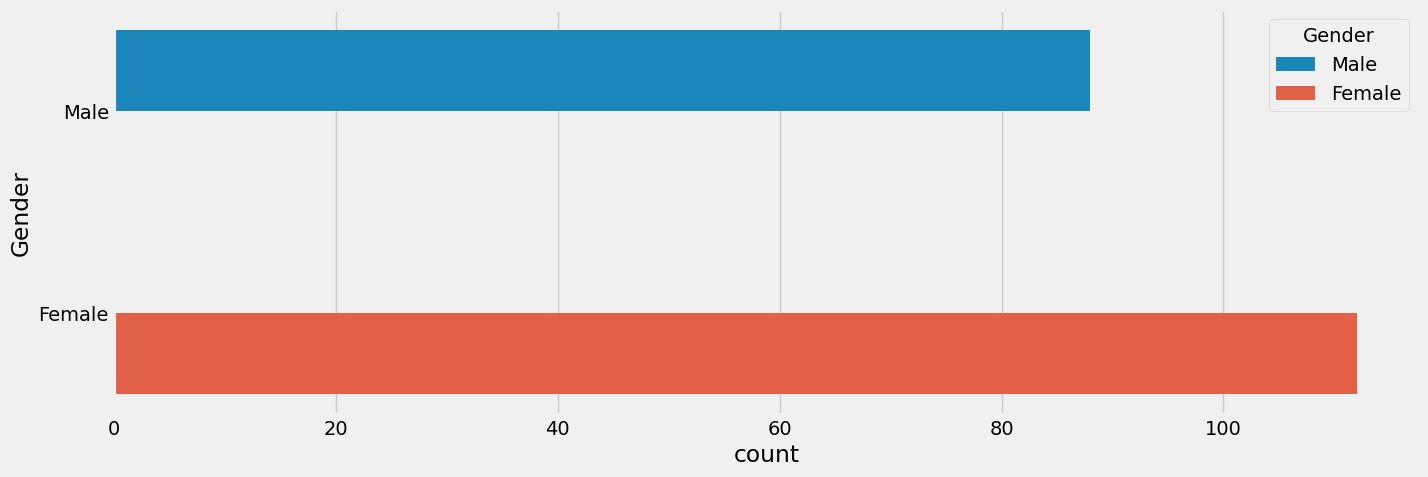

In [12]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Gender' , data = df, hue='Gender')
plt.show()

Ploting the Relation between Age , Annual Income and Spending Score

In [13]:
# hello 

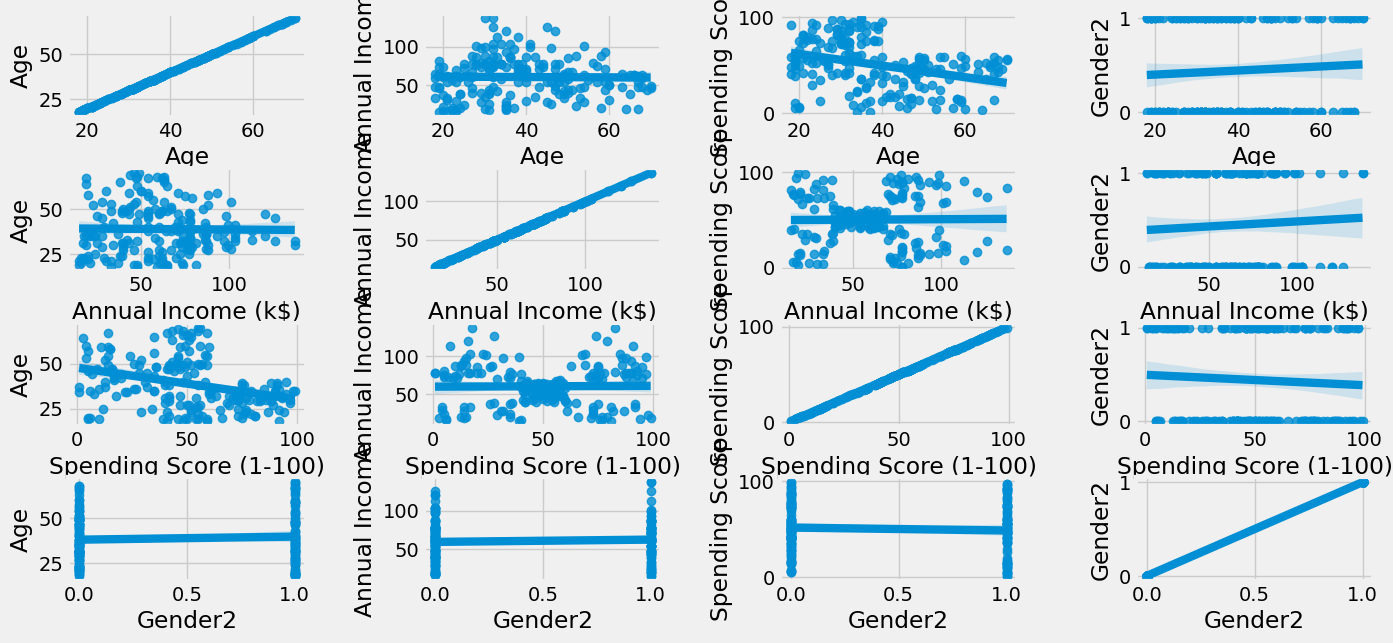

In [14]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for x in df2.columns:
    for y in df2.columns:
        n += 1
        plt.subplot(len(df2.columns) , len(df2.columns) , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

In [15]:
df2.corr()

,Age,Annual Income (k$),Spending Score (1-100),Gender2
Age,1.000000,-0.012398,-0.327227,0.060867
Annual Income (k$),-0.012398,1.000000,0.009903,0.056410
Spending Score (1-100),-0.327227,0.009903,1.000000,-0.058109
Gender2,0.060867,0.056410,-0.058109,1.000000


<Axes: >

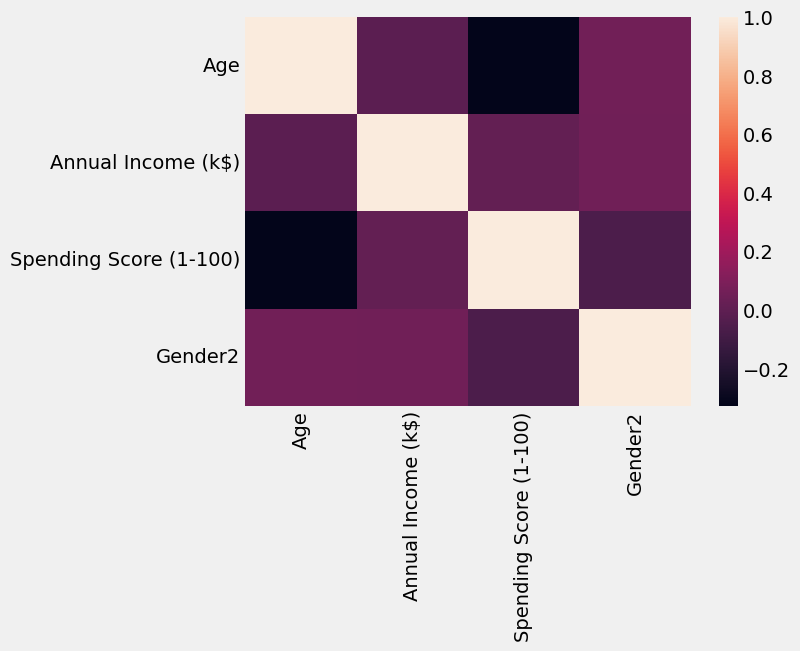

In [16]:
sns.heatmap(df2.corr())

I must say it makes good sense to see negative correlation between Age and Spending Score, People with greater age spend less (wisdom speaks)

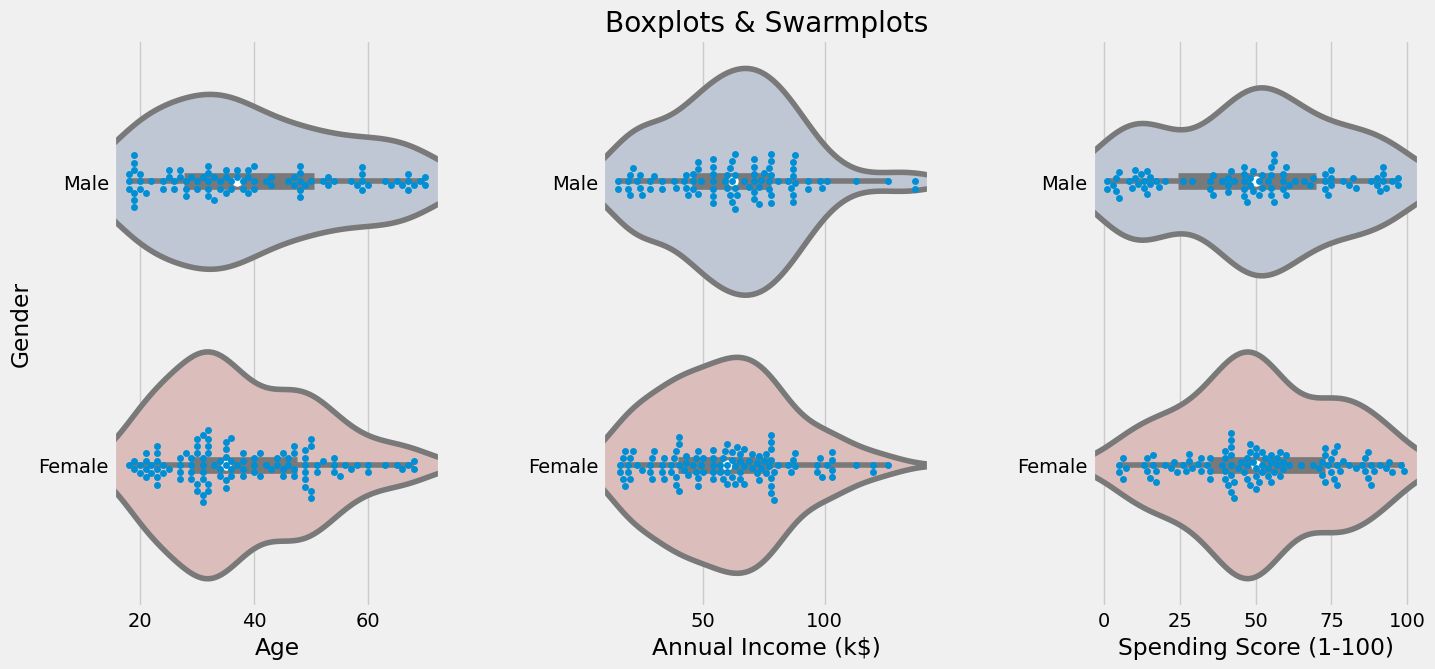

In [17]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for cols in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1 
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.violinplot(x = cols , y = 'Gender' , data = df , palette = 'vlag')
    sns.swarmplot(x = cols , y = 'Gender' , data = df)
    plt.ylabel('Gender' if n == 1 else '')
    plt.title('Boxplots & Swarmplots' if n == 2 else '')
plt.show()

In [18]:
x = df2.values

# Standardize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Model Building

try it all

## Functions

In [19]:
def plot_silhouette(name, cluster_labels, x, ax=None, **kwargs):

    if ax is None:
        fig, ax = plt.subplots()

    # Compute silhouette score
    n_clusters = np.unique(cluster_labels).size
    
    silhouette_avg = silhouette_score(x, cluster_labels)    
    ax.set_title(f"{name} - Silhouette Score: {silhouette_avg:.2f}")

    # Compute silhouette values for each data point
    sample_silhouette_values = silhouette_samples(x, cluster_labels)

    y_lower = 10
    for i in range(cluster_labels.max() + 1):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.Spectral(float(i) / cluster_labels.max())
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7, **kwargs)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster label")
    ax.set_title(f"{name}: Clusters({cluster_labels.max() + 1}) Silhouette Score({silhouette_avg:.2f})")
    # The vertical line for the average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_xlim(-0.2, 1)

    return ax



In [20]:

def get_cluster_centers(X, cluster_labels, n_clusters):
    centers = np.zeros((n_clusters, X.shape[1]))
    for i in range(n_clusters):
        centers[i] = np.mean(X[cluster_labels == i], axis=0)
    return centers

In [21]:
def plot_scatter_2d(x, cluster_labels, ax=None, random_state=42, **kwargs):
    n_clusters = len(np.unique(cluster_labels))
        
    if x.shape[-1] < 2:
        x = PolynomialFeatures(2).fit_transform(x)

    if x.shape[-1] != 2:
        x = TSNE(n_components=2, random_state=random_state).fit_transform(x)
        
    if ax is None:
        fig, ax = plt.subplots()
        
    if 'c' not in kwargs:
        kwargs['c'] = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    ax.scatter(x[:, 0], x[:, 1], **kwargs)
    
    centers = get_cluster_centers(x, cluster_labels, n_clusters)
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers,1):
        ax.scatter(c[0], c[1], marker="$%d$" % i)

    return ax

In [22]:

def plot_scatter_3d(x, cluster_labels, n_clusters=None, ax=None, random_state=42,**kwargs):
    
    
    if n_clusters is None:
        n_clusters = len(np.unique(cluster_labels))

    if x.shape[-1] < 3:
        x = PolynomialFeatures(2).fit_transform(x)
        
    if x.shape[-1] != 3:
        x = TSNE(n_components=3, random_state=random_state).fit_transform(x)
        
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
    if 'c' not in kwargs:
        kwargs['c'] = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)


    ax.scatter(X[:, 0], X[:, 1], X[:, 2], **kwargs)

    centers = get_cluster_centers(X, cluster_labels, n_clusters)
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        centers[:, 2],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers, 1):
        ax.scatter(c[0], c[1], c[2], marker="$%d$" % i)

    return ax

In [23]:
def plot_datapoints(x, y, n_components=2, **kwargs):
    
    if n_components not in [2, 3]:
        raise ValueError("n_components must be in [2, 3]")
        
    if x.shape[-1] != n_components:
        x = TSNE(n_components=n_components, random_state=42).fit_transform(x)
    
    x = pd.DataFrame(x, columns=["x", "y", "z"] if n_components == 3 else ["x", "y"])
    x['cluster']=y
    x['cluster'] = x['cluster'].astype('category')
    if n_components == 2:
        fig=px.scatter(data_frame=x, x='x', y='y', color='cluster', symbol='cluster', **kwargs)
    elif n_components == 3:
        fig=px.scatter_3d(data_frame=x, x='x', y='y', z='z', color='cluster', symbol='cluster', **kwargs)
    
    fig.show()


# Tune

In [24]:
bandwidth = [estimate_bandwidth(x_scaled, quantile=quantile, n_samples=10) for quantile in np.linspace(0.35, 1.0, 10)]

In [25]:
bandwidth

[1.6327490378927465,
 2.066380931911182,
 2.066380931911182,
 2.15674589503544,
 2.426318086244577,
 2.7087152452708496,
 2.7087152452708496,
 2.925433593915991,
 3.4040782290687703,
 4.085696524791209]

In [26]:
# np.linspace(0.5,1, 10)
np.arange(2,20)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])

In [27]:
params = {
    'ap': {
        'damping': [0.5       , 0.55444444, 0.60888889, 0.66333333, 0.71777778,
       0.77222222, 0.82666667, 0.88111111, 0.93555556, 0.99      ] ,
        'convergence_iter': [10, 12, 14, 16, 18, 20, 22, 24, 15] ,
        'affinity': ['euclidean'],
        'random_state':[random_seed],

    },
    'kmeans': {
        'n_clusters': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        'init':['k-means++', 'random'], 
        'n_init': ['auto'],
        'tol':[0.001, 0.01, 0.1],
    },

    'meanshift':{
        'bandwidth':bandwidth,
    },
    'dbscan':{
#         'eps':[0.51, 0.6, 0.7, 0.8, 0.9, 0.99],
        'eps':[0.5       , 0.55555556, 0.61111111, 0.66666667, 0.72222222,
       0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ],
        'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    },
    'spectral':{
        'eigen_solver':['arpack', 'lobpcg'],
        'n_clusters': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        'n_init':[ 5,  7,  9, 11, 13, 15, 17, 19],
        'gamma':[0.5       , 0.665, 0.831, 0.996, 1.162,
       1.327, 1.493, 1.658, 1.824, 1.99      ],
#         'affinity':['rbf', 'nearest_neighbors', 'precomputed_nearest_neighbors'],
        'n_neighbors': [ 5,  7,  9, 11, 13, 15, 17, 19],
        'random_state':[random_seed],

    },
    'agg':{
        'n_clusters': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
#         'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
        'linkage': ['ward', 'complete', 'average', 'single'],
        'compute_distances': [True, False]
    },
    'hdbscan':{
        'min_cluster_size': [10, 15, 20], 
        'min_samples': [None, 5, 10, 15],
        'metric': ['euclidean', 'manhattan'], #, 'cosine'], 'precomputed'], 
        'alpha': [1.0, 0.5, 1.5],
        'algorithm': ['auto', 'brute', 'kdtree', 'balltree'],
        'cluster_selection_method': ['eom', 'leaf'],
    },
    'birch':{
        'threshold': [0.1, 0.3, 0.5, 0.7],
        'branching_factor': [10, 30, 50, 70],
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
    },
    'optics':{
#         'max_eps': np.linspace(0.1, 0.99, 10),
        'metric': ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan'],
        'p': [1, 2, 3],
        'cluster_method': ['xi', 'dbscan'],
#         'eps': [None, 0.1, 0.5, 1.0, 2.0],
        'xi': [0.01, 0.05, 0.1, 0.2],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 30, 50, 100]
    },
    'gmm':{
        'n_components': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1],
        'reg_covar': [1e-7, 1e-6, 1e-5],
        'n_init': [1, 5, 10],
        'init_params': ['kmeans', 'k-means++', 'random'],
        'random_state':[random_seed],
    },
    'bgmm':{
        'n_components': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],

        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1],
        'reg_covar': [1e-7, 1e-6, 1e-5],
        'n_init': [1, 5, 10],
        'init_params': ['kmeans', 'k-means++', 'random']
    },
    'bkmeans':{
                'n_clusters': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],

        'init': ['k-means++','random'],
        'n_init': [1, 5, 10],
        'tol': [1e-4, 1e-3, 1e-2],
        'algorithm': [ 'elkan', 'lloyd'],
        'bisecting_strategy': ['biggest_inertia', 'largest_cluster'],
    },
    'mini_batch_kmeans':{
        'n_clusters': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        'init': ['k-means++','random'],
        'batch_size': [2, 4, 8, 16],
        'random_state':[random_seed],
    }
}

In [28]:
models = {
    "kmeans": KMeans(),
    "ap": AffinityPropagation(),
    'gmm':mixture.GaussianMixture(),
    'bgmm':mixture.BayesianGaussianMixture(),
    "meanshift": MeanShift(),
    'dbscan': DBSCAN(),
    'spectral':cluster.SpectralClustering(),
    'agg': cluster.AgglomerativeClustering(),
    'birch': cluster.Birch(),
#     'hdbscan':cluster.HDBSCAN(), #uncomment if using sklearn >=1.3
    'optics':cluster.OPTICS(),
    'bkmeans':cluster.BisectingKMeans(),
    'mini_batch_kmeans':cluster.MiniBatchKMeans(),
}

In [29]:

class ClusterRandomizedSearch:
    def __init__(self, model, param_distributions, n_iter=10, scoring='silhouette_score', random_state=None):
        '''
        'Higher Calinski-Harabasz score relates to a model with better-defined clusters.'
        'Higher Silhouette score relates to a model with better-defined clusters.'
        'Lower Davies-Bouldin index relates to a model with better separation between the clusters.'
        '''
        self.model = model
        self.param_distributions = param_distributions

        if isinstance(scoring, str):
            scoring = [scoring]
        elif not isinstance(scoring, list):
            raise ValueError(f"Scoring must be a string or a list of strings. Values can be {self.get_scorer()}")

        self.scoring = scoring
        self.random_state = random_state
        self.results = []
        self.combinations = self.get_all_combinations(self.param_distributions)
        random.shuffle(self.combinations)
        self.used_combinations = set()
        self.n_iter = min(n_iter, len(self.combinations))
        self.model_name = model.__class__.__name__
        
    def fit(self, X):
        np.random.seed(self.random_state)
        for i in range(self.n_iter):
            params = self.combinations.pop()
            
            try: 
                model = self.model.set_params(**params)
                labels = model.fit_predict(X)
            except Exception as e:
                print('Model: ', self.model_name)
                print('Params: ', params)
                raise e
                
            n_clusters = np.unique(labels).size
            
            all_scores = {}
            for scoring_ in self.scoring:
                score = self._evaluate_score(X, labels, scoring_)
                all_scores.update(score)
            self.results.append({'params': params, 'name': self.model_name, 'n_clusters':n_clusters, **all_scores})

        best_result = max(self.results,default=np.nan, key=lambda x: x[self.scoring[0]])
        self.best_params_ = best_result['params']
        self.best_score_ = best_result[self.scoring[0]]
        self.best_estimator_ = self.model.set_params(**self.best_params_)
        self.n_clusters_ = best_result['n_clusters']

    def _get_random_params(self):
        for param in self.combinations:
            yield {key: value for key, value in param.items()}

    def get_all_combinations(self, parameter_dict):
        parameter_names = list(parameter_dict.keys())
        parameter_values = list(parameter_dict.values())

        combinations = list(product(*parameter_values))
        return [{param_name: value for param_name, value in zip(parameter_names, combo)} for combo in combinations]
    
    def get_scorer(self):
            return {'silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score'}
        
    def _evaluate_score(self, X, labels, scoring):
        n_clusters = np.unique(labels).size
        
        if n_clusters == 1:
            score=np.nan
        elif scoring == 'silhouette_score':
            score = silhouette_score(X, labels)
        elif scoring == 'davies_bouldin_score':
            score = metrics.davies_bouldin_score(X, labels)
        elif scoring == 'calinski_harabasz_score':
            score = metrics.calinski_harabasz_score(X, labels)
        else:
            raise ValueError(f"Invalid scoring metric: {scoring}")

        return {scoring: score}
    
    def results_(self):        
        results_df = pd.DataFrame(self.results)
        param_columns = list(self.param_distributions.keys())
        for param_column in param_columns:
            results_df[f'param_{param_column}'] = results_df['params'].apply(lambda x: x[param_column])

        return results_df

In [30]:
scorrr = ['silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score']

In [31]:
model_grid_search = {}
n_iter=150
for i in models:
    print(i)
    tuner = ClusterRandomizedSearch(models[i], params[i], n_iter, scoring=scorrr, random_state=42)
    tuner.fit(x_scaled)

    print('Total Combinations: ',len(tuner.get_all_combinations(params[i])))
    print('Best Parameters:', tuner.best_params_)
    print('Best Score:', tuner.best_score_)
    print('Clusters:',tuner.n_clusters_)
    
    model_grid_search[i] = tuner
    print()


kmeans
Total Combinations:  108
Best Parameters: {'n_clusters': 15, 'init': 'k-means++', 'n_init': 'auto', 'tol': 0.001}
Best Score: 0.4340312916462814
Clusters: 15

ap
Total Combinations:  90
Best Parameters: {'damping': 0.93555556, 'convergence_iter': 24, 'affinity': 'euclidean', 'random_state': 69}
Best Score: 0.41336515636108245
Clusters: 16

gmm
Total Combinations:  7776
Best Parameters: {'n_components': 15, 'covariance_type': 'tied', 'tol': 0.1, 'reg_covar': 1e-05, 'n_init': 10, 'init_params': 'kmeans', 'random_state': 69}
Best Score: 0.4334318640803575
Clusters: 15

bgmm
Total Combinations:  7776
Best Parameters: {'n_components': 17, 'covariance_type': 'tied', 'tol': 0.001, 'reg_covar': 1e-07, 'n_init': 5, 'init_params': 'kmeans'}
Best Score: 0.43349065248226154
Clusters: 13

meanshift
Total Combinations:  10
Best Parameters: {'bandwidth': 2.7087152452708496}
Best Score: nan
Clusters: 1

dbscan
Total Combinations:  40
Best Parameters: {'eps': 0.88888889, 'algorithm': 'brute'}
Be

        'Higher Calinski-Harabasz score relates to a model with better-defined clusters.'
        'Higher Silhouette score relates to a model with better-defined clusters.'
        'Lower Davies-Bouldin index relates to a model with better separation between the clusters.'

In [32]:
big_results_df = pd.DataFrame()
for model in model_grid_search:
    a = model_grid_search[model].results_()
    aa = a.sort_values('silhouette_score', ascending=False).head(3)
    print(model)
    pp = aa[['params', 'name', 'n_clusters']+scorrr]
    display(aa)
    
    big_results_df = pd.concat([big_results_df, pp])

kmeans


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score,param_n_clusters,param_init,param_n_init,param_tol
73,"{'n_clusters': 15, 'init': 'k-means++', 'n_ini...",KMeans,15,0.434031,0.780091,92.337358,15,k-means++,auto,0.001
31,"{'n_clusters': 12, 'init': 'random', 'n_init':...",KMeans,12,0.430959,0.818535,91.422853,12,random,auto,0.010
69,"{'n_clusters': 11, 'init': 'random', 'n_init':...",KMeans,11,0.430473,0.813218,91.396956,11,random,auto,0.010


ap


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score,param_damping,param_convergence_iter,param_affinity,param_random_state
0,"{'damping': 0.93555556, 'convergence_iter': 24...",AffinityPropagation,16,0.413365,0.813995,91.302113,0.935556,24,euclidean,69
61,"{'damping': 0.77222222, 'convergence_iter': 12...",AffinityPropagation,16,0.413365,0.813995,91.302113,0.772222,12,euclidean,69
35,"{'damping': 0.88111111, 'convergence_iter': 15...",AffinityPropagation,16,0.413365,0.813995,91.302113,0.881111,15,euclidean,69


gmm


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score,param_n_components,param_covariance_type,param_tol,param_reg_covar,param_n_init,param_init_params,param_random_state
31,"{'n_components': 15, 'covariance_type': 'tied'...",GaussianMixture,15,0.433432,0.760521,91.054674,15,tied,0.1000,1.000000e-05,10,kmeans,69
146,"{'n_components': 11, 'covariance_type': 'spher...",GaussianMixture,11,0.430427,0.813381,91.371818,11,spherical,0.0001,1.000000e-07,5,kmeans,69
10,"{'n_components': 11, 'covariance_type': 'tied'...",GaussianMixture,11,0.429856,0.817023,90.833277,11,tied,0.0010,1.000000e-07,5,kmeans,69


bgmm


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score,param_n_components,param_covariance_type,param_tol,param_reg_covar,param_n_init,param_init_params
85,"{'n_components': 17, 'covariance_type': 'tied'...",BayesianGaussianMixture,13,0.433491,0.793092,91.600286,17,tied,0.001,1.000000e-07,5,kmeans
46,"{'n_components': 13, 'covariance_type': 'spher...",BayesianGaussianMixture,11,0.430628,0.810848,91.196988,13,spherical,0.001,1.000000e-07,5,k-means++
38,"{'n_components': 15, 'covariance_type': 'spher...",BayesianGaussianMixture,11,0.430628,0.810848,91.196988,15,spherical,0.010,1.000000e-05,10,k-means++


meanshift


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score,param_bandwidth
5,{'bandwidth': 1.6327490378927465},MeanShift,3,0.26226,1.459046,54.006704,1.632749
0,{'bandwidth': 2.7087152452708496},MeanShift,1,NaN,NaN,NaN,2.708715
1,{'bandwidth': 2.925433593915991},MeanShift,1,NaN,NaN,NaN,2.925434


dbscan


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score,param_eps,param_algorithm
37,"{'eps': 0.88888889, 'algorithm': 'ball_tree'}",DBSCAN,3,0.254586,3.760493,32.909312,0.888889,ball_tree
30,"{'eps': 0.88888889, 'algorithm': 'auto'}",DBSCAN,3,0.254586,3.760493,32.909312,0.888889,auto
26,"{'eps': 0.88888889, 'algorithm': 'kd_tree'}",DBSCAN,3,0.254586,3.760493,32.909312,0.888889,kd_tree


spectral


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score,param_eigen_solver,param_n_clusters,param_n_init,param_gamma,param_n_neighbors,param_random_state
4,"{'eigen_solver': 'arpack', 'n_clusters': 15, '...",SpectralClustering,15,0.430672,0.737466,87.571246,arpack,15,13,1.162,13,69
52,"{'eigen_solver': 'lobpcg', 'n_clusters': 15, '...",SpectralClustering,15,0.430533,0.737578,87.454394,lobpcg,15,9,1.824,11,69
90,"{'eigen_solver': 'arpack', 'n_clusters': 15, '...",SpectralClustering,15,0.430533,0.737578,87.454394,arpack,15,11,1.824,5,69


agg


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score,param_n_clusters,param_linkage,param_compute_distances
34,"{'n_clusters': 16, 'linkage': 'ward', 'compute...",AgglomerativeClustering,16,0.439323,0.761116,88.620958,16,ward,False
11,"{'n_clusters': 16, 'linkage': 'ward', 'compute...",AgglomerativeClustering,16,0.439323,0.761116,88.620958,16,ward,True
113,"{'n_clusters': 16, 'linkage': 'average', 'comp...",AgglomerativeClustering,16,0.438663,0.711817,82.344705,16,average,True


birch


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score,param_threshold,param_branching_factor,param_n_clusters
75,"{'threshold': 0.5, 'branching_factor': 70, 'n_...",Birch,9,0.40012,0.89812,81.80029,0.5,70,9
110,"{'threshold': 0.5, 'branching_factor': 30, 'n_...",Birch,9,0.40012,0.89812,81.80029,0.5,30,9
24,"{'threshold': 0.5, 'branching_factor': 50, 'n_...",Birch,9,0.40012,0.89812,81.80029,0.5,50,9


optics


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score,param_metric,param_p,param_cluster_method,param_xi,param_algorithm,param_leaf_size
147,"{'metric': 'l1', 'p': 2, 'cluster_method': 'xi...",OPTICS,14,0.159597,1.440315,22.272222,l1,2,xi,0.01,brute,100
62,"{'metric': 'cityblock', 'p': 1, 'cluster_metho...",OPTICS,14,0.159597,1.440315,22.272222,cityblock,1,xi,0.01,kd_tree,50
118,"{'metric': 'cityblock', 'p': 1, 'cluster_metho...",OPTICS,14,0.159597,1.440315,22.272222,cityblock,1,xi,0.01,brute,10


bkmeans


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score,param_n_clusters,param_init,param_n_init,param_tol,param_algorithm,param_bisecting_strategy
149,"{'n_clusters': 11, 'init': 'k-means++', 'n_ini...",BisectingKMeans,11,0.422659,0.841579,88.807620,11,k-means++,1,0.001,lloyd,largest_cluster
145,"{'n_clusters': 11, 'init': 'random', 'n_init':...",BisectingKMeans,11,0.422659,0.841579,88.807620,11,random,1,0.001,elkan,largest_cluster
113,"{'n_clusters': 11, 'init': 'random', 'n_init':...",BisectingKMeans,11,0.422046,0.842558,89.024404,11,random,1,0.010,elkan,biggest_inertia


mini_batch_kmeans


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score,param_n_clusters,param_init,param_batch_size,param_random_state
119,"{'n_clusters': 14, 'init': 'k-means++', 'batch...",MiniBatchKMeans,14,0.402211,0.817807,86.502234,14,k-means++,16,69
11,"{'n_clusters': 11, 'init': 'k-means++', 'batch...",MiniBatchKMeans,11,0.394920,0.872852,78.655781,11,k-means++,16,69
123,"{'n_clusters': 14, 'init': 'random', 'batch_si...",MiniBatchKMeans,14,0.390031,0.850787,77.692954,14,random,4,69


# Big DF

        'Higher Calinski-Harabasz score relates to a model with better-defined clusters.'
        'Higher Silhouette score relates to a model with better-defined clusters.'
        'Lower Davies-Bouldin index relates to a model with better separation between the clusters.'

In [33]:
big_results_df.sort_values(['silhouette_score', 'calinski_harabasz_score'], ascending=False).sort_values(['davies_bouldin_score', 'n_clusters'], ascending=True).head(10)

,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
113,"{'n_clusters': 16, 'linkage': 'average', 'comp...",AgglomerativeClustering,16,0.438663,0.711817,82.344705
4,"{'eigen_solver': 'arpack', 'n_clusters': 15, '...",SpectralClustering,15,0.430672,0.737466,87.571246
52,"{'eigen_solver': 'lobpcg', 'n_clusters': 15, '...",SpectralClustering,15,0.430533,0.737578,87.454394
90,"{'eigen_solver': 'arpack', 'n_clusters': 15, '...",SpectralClustering,15,0.430533,0.737578,87.454394
31,"{'n_components': 15, 'covariance_type': 'tied'...",GaussianMixture,15,0.433432,0.760521,91.054674
34,"{'n_clusters': 16, 'linkage': 'ward', 'compute...",AgglomerativeClustering,16,0.439323,0.761116,88.620958
11,"{'n_clusters': 16, 'linkage': 'ward', 'compute...",AgglomerativeClustering,16,0.439323,0.761116,88.620958
73,"{'n_clusters': 15, 'init': 'k-means++', 'n_ini...",KMeans,15,0.434031,0.780091,92.337358
85,"{'n_components': 17, 'covariance_type': 'tied'...",BayesianGaussianMixture,13,0.433491,0.793092,91.600286
38,"{'n_components': 15, 'covariance_type': 'spher...",BayesianGaussianMixture,11,0.430628,0.810848,91.196988


# Fine tuned models

In [34]:
fine_tunes_models = {}

In [35]:
for name, cv in model_grid_search.items():
    fine_tunes_models[name] = cv.best_estimator_

# 2D Plots

In [36]:
len(fine_tunes_models)

12

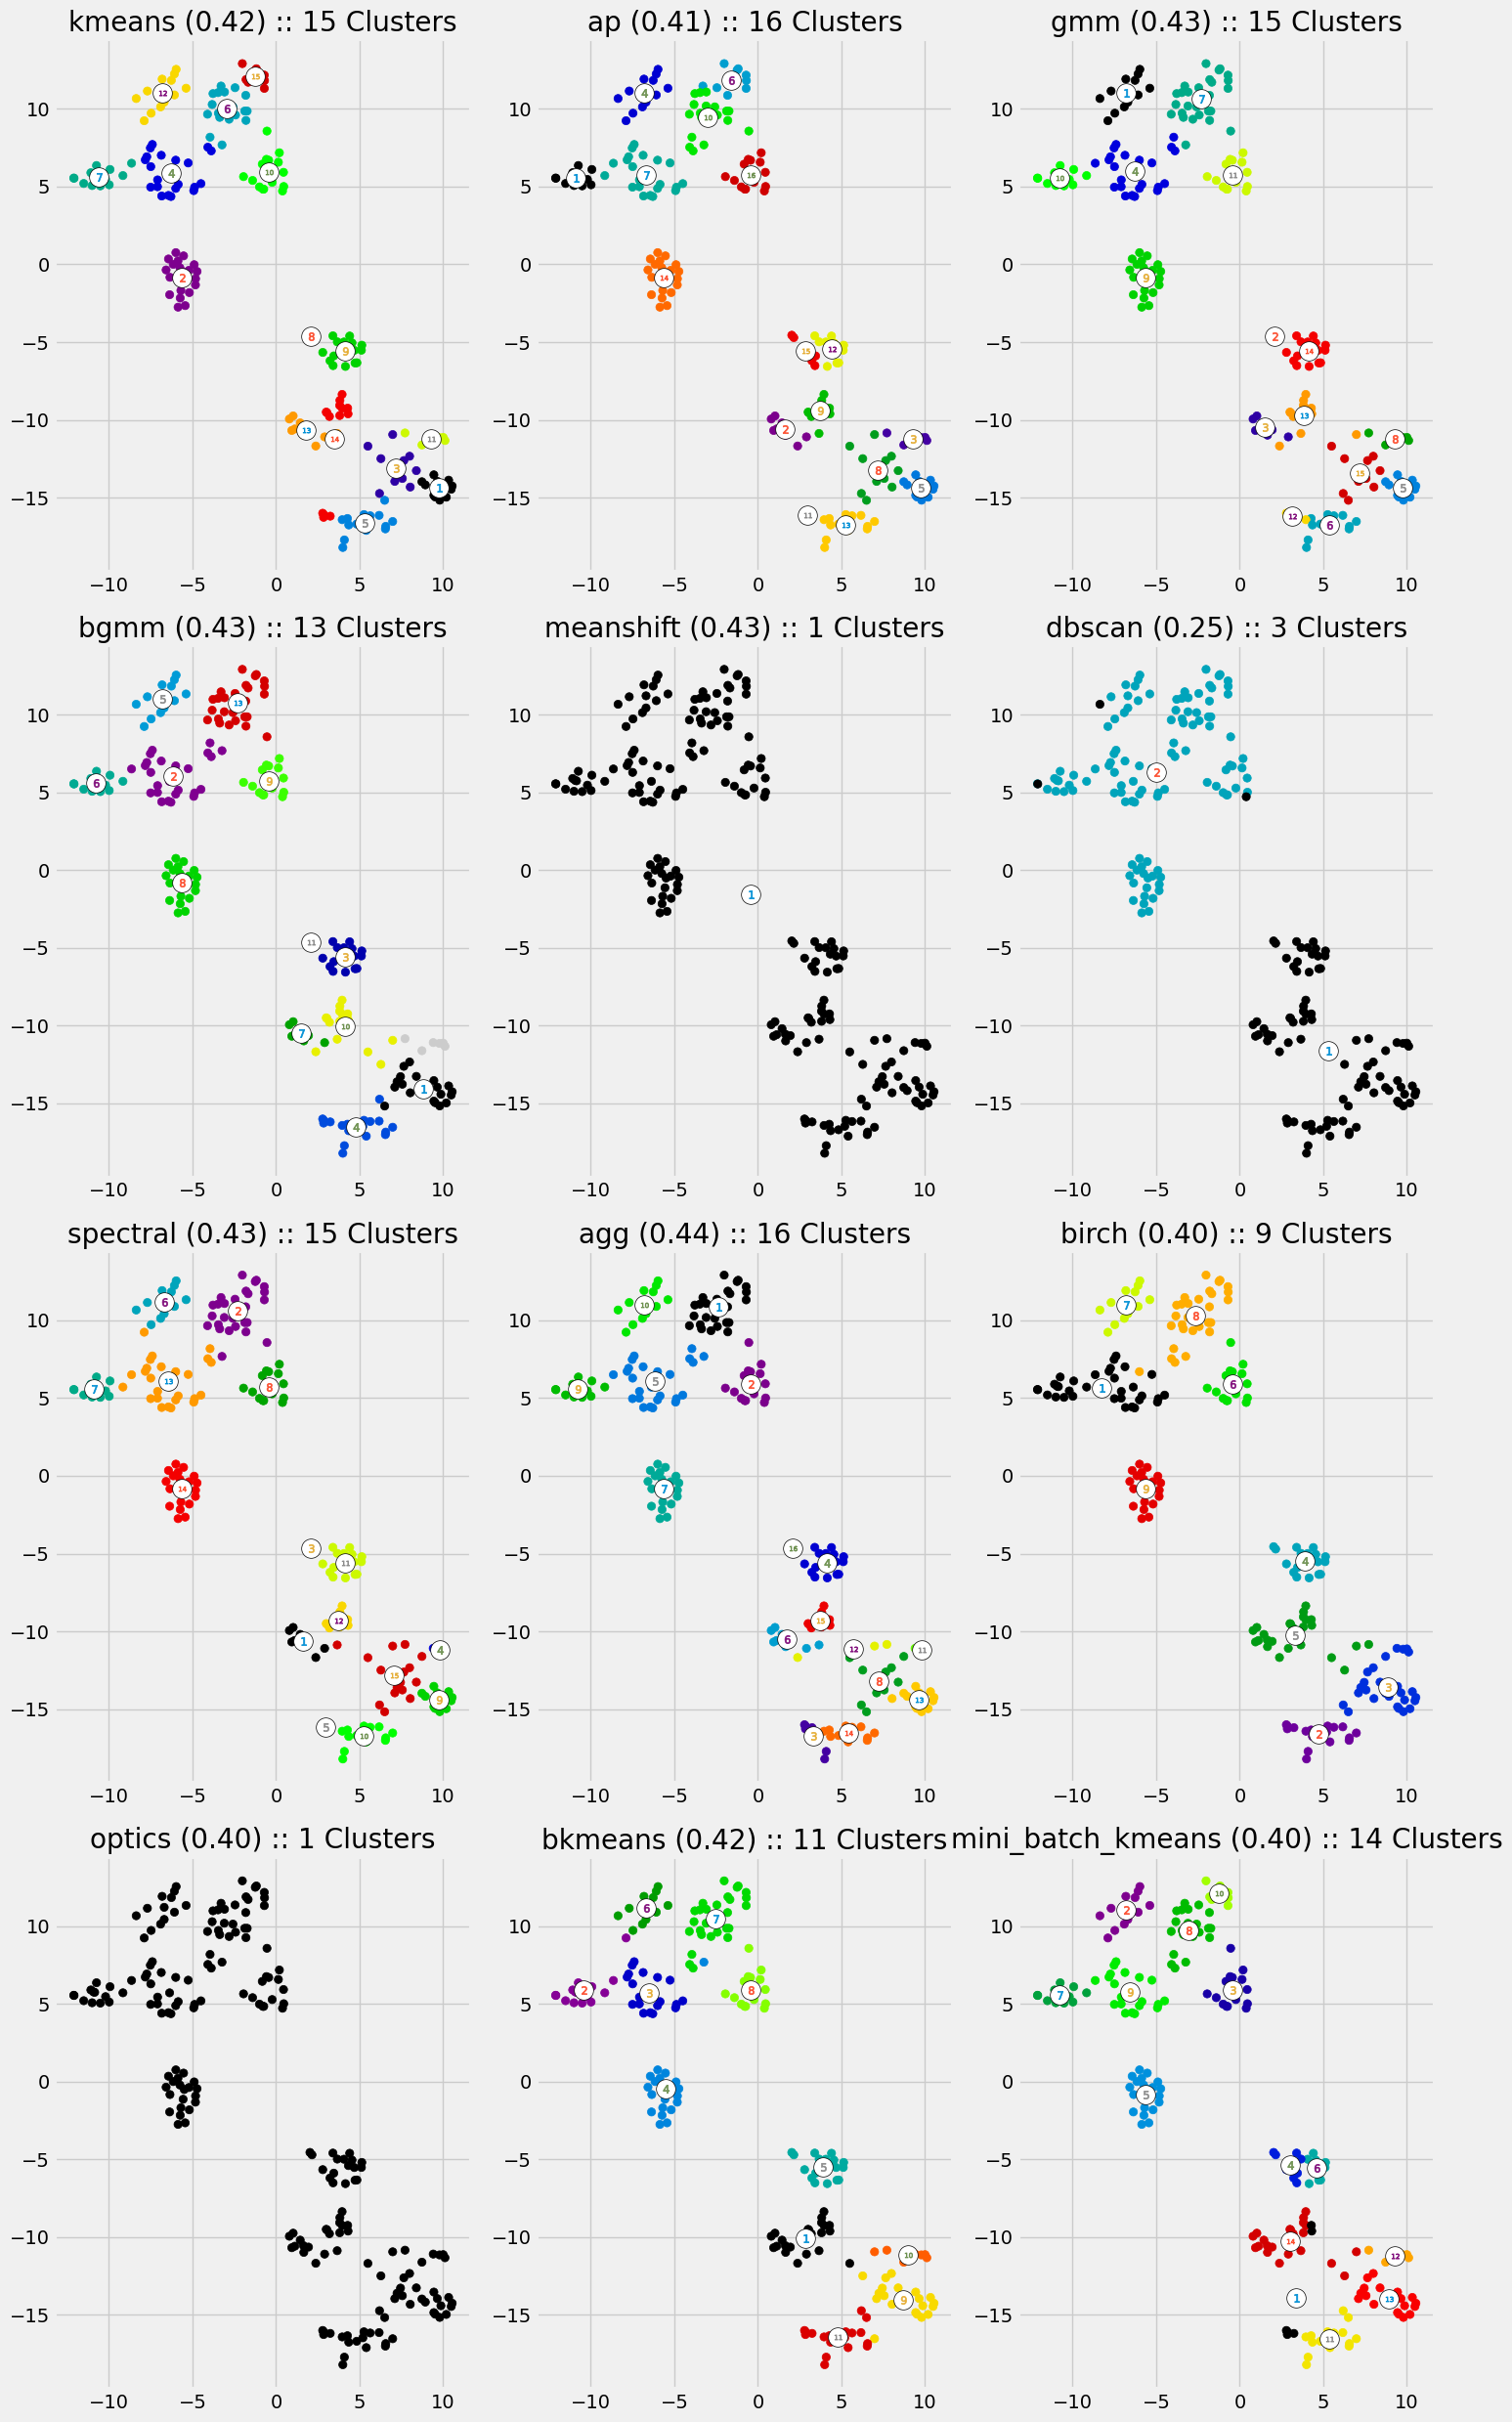

In [37]:
n_cols = 3
n_rows = math.ceil(fine_tunes_models.__len__() / n_cols)
# Create a 4x3 grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 25))

plot_n = 0
for name, model in fine_tunes_models.items():
    model.fit(x_scaled)

    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(x_scaled)

    cluster_num = len(np.unique(y_pred))
    
    if cluster_num > 1:
        
        score = silhouette_score(x_scaled, y_pred)

    plot_scatter_2d(x_scaled, y_pred, ax=axes[plot_n // 3, plot_n % 3])
    axes[plot_n // 3, plot_n % 3].set_title(f'{name} ({score:.2f}) :: {cluster_num} Clusters')

    plot_n += 1

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# 3D Plots

In [38]:
nn = 1
for name, model in fine_tunes_models.items():
    model.fit(x_scaled)

    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(x_scaled)  # Use x_scaled, not X
    
    n_clusters = np.unique(y_pred).size
    if n_clusters > 1:
        score = silhouette_score(x_scaled, y_pred)
    plot_datapoints(x_scaled, y_pred, n_components=3, title=f'{nn}. {name}({score:.2f})::({n_clusters} Clusters)')
        
    nn += 1
#     print(nn)

Some of the Datapoints are in same cluster but in different places. It just may be because of projection in lower dimensions.

# Sihouette Plots

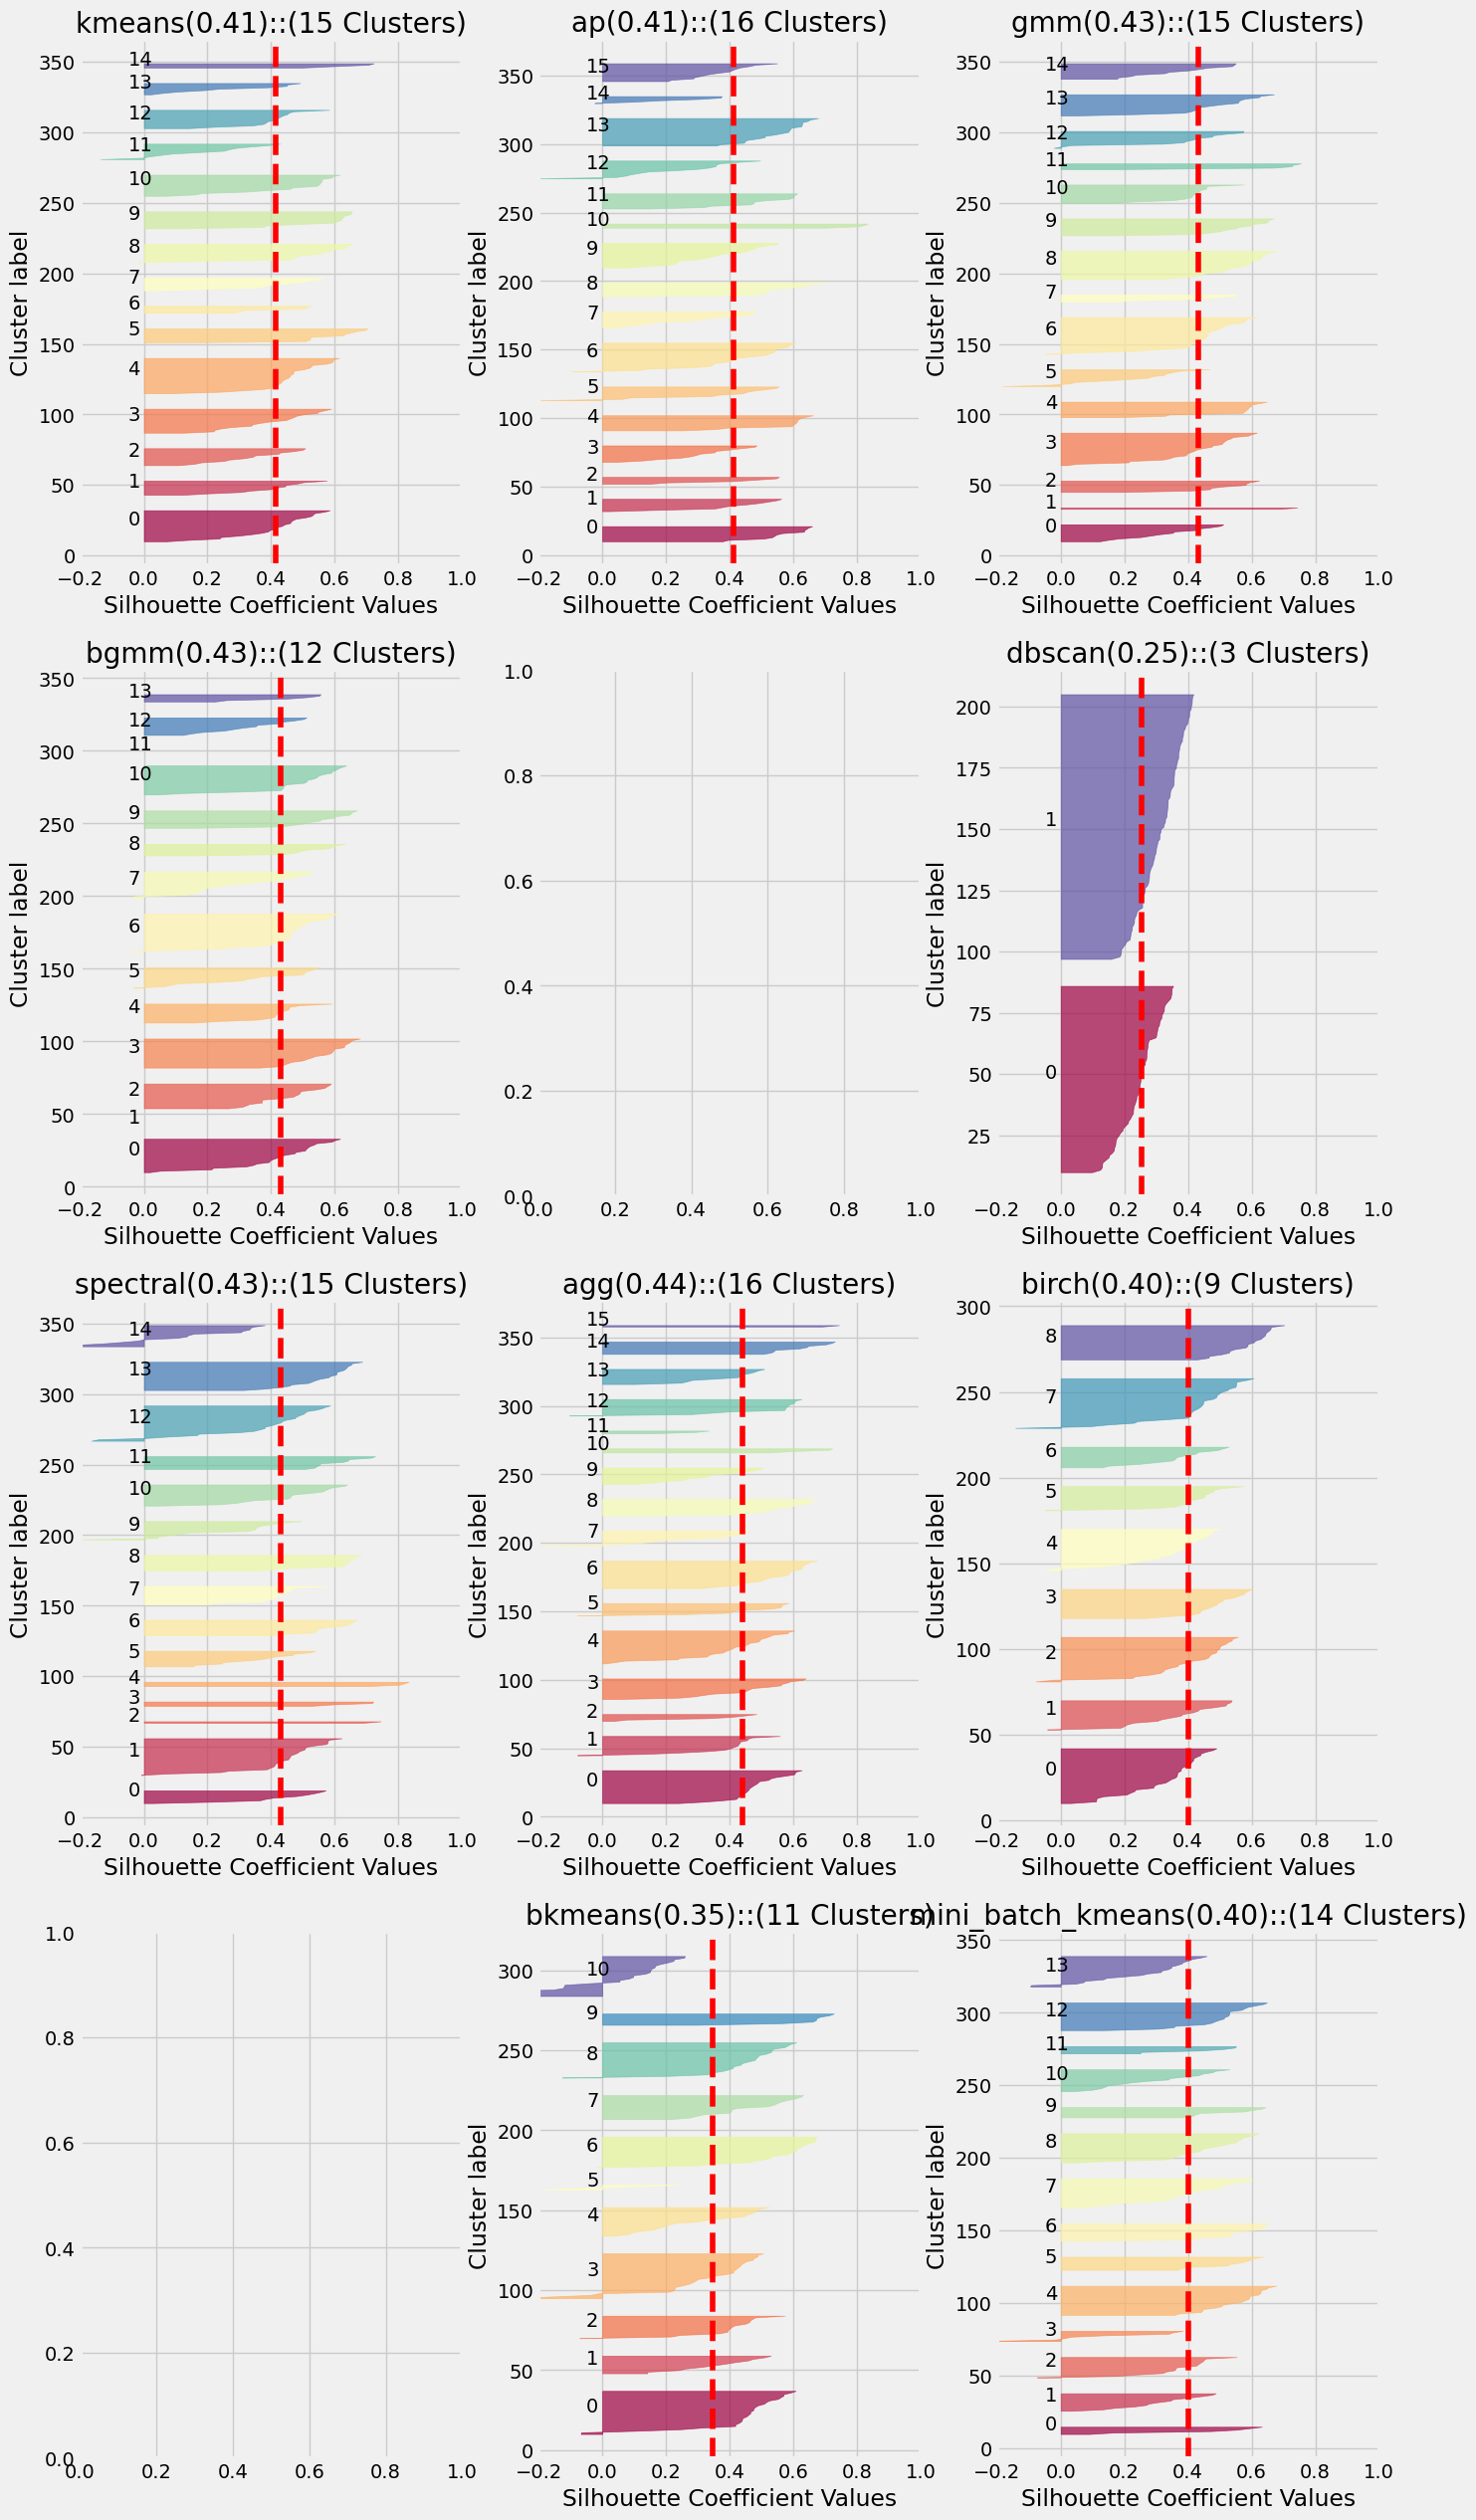

In [39]:



fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 30))

plot_n = 0
for name, model in fine_tunes_models.items():
    model.fit(x_scaled)

    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(x_scaled)
    
    n_clusters = len(np.unique(y_pred))
    
    score = 0
    # wont plot for just one cluster
    if n_clusters > 1:
        score = silhouette_score(x_scaled, y_pred)
        plot_silhouette(name, y_pred, x_scaled, ax=ax[plot_n // 3, plot_n % 3])
        ax[plot_n // 3, plot_n % 3].set_title(f'{name}({score:.2f})::({n_clusters} Clusters)')

    plot_n += 1

plt.show()

# Conclusion

Given the Cluster plots and silhouette scores for each model the optimum number of well defined clusters is among 6-10.
Any model with Silhouette score above 0.35 is considered to be a good model here.

So, 

1. Kmeans (it will get higher sil score for more number of clusters, so clusters between 8-12 would be good, good number of datapoints in each group) 
2. BKmeans
3. Birch
4. BGMM
5. Spectral
6. Agg
7. GMM
8. Mini Batch Kmeans

Not in a Particular Order, but i like Birch here for two reason
1. 9 Cluster for 200 datapoints (not too many , not too less)
2. Good Scores 

# Saving the models

In [40]:
good_models = ['kmeans','mini_batch_kmeans','birch','bgmm', 'gmm','spectral','agg']

In [41]:
model_dir = Path('models')
model_dir.mkdir(exist_ok=True)

pipes  = {}
for model in good_models:
    best_one=fine_tunes_models[model]
    
    pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  
            ('scaler', StandardScaler()),  
            (model, best_one)
    ])
    pipes[model] = pipeline
    pipeline.fit(x_scaled)

    filename = model_dir/f'{model}_pipeline.pkl'
    pickle.dump(pipeline, open(filename, 'wb'))

# Testing Pipeline

Trying to Recreate the same output as above

In [42]:

a = pipes['kmeans']

In [43]:
a

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=15, n_init='auto', tol=0.001))])

In [44]:
x[:10,:] #DATA

array([[19, 15, 39,  1],
       [21, 15, 81,  1],
       [20, 16,  6,  0],
       [23, 16, 77,  0],
       [31, 17, 40,  0],
       [22, 17, 76,  0],
       [35, 18,  6,  0],
       [23, 18, 94,  0],
       [64, 19,  3,  1],
       [30, 19, 72,  0]])

In [45]:
aa = a.fit(x)

In [46]:
aa.named_steps['kmeans'].labels_

array([ 3, 13, 10,  2, 10,  2, 10,  2,  6,  2,  6,  2, 10,  2,  6, 13, 10,
       13,  6,  2,  3, 13, 10, 13, 10, 13, 10, 13, 10,  2,  6,  2,  6, 13,
       10,  2, 10,  2, 10,  2, 12, 13,  8,  9, 10,  2,  0,  9,  9,  9,  0,
        3,  9,  8,  0,  8,  0,  8,  9,  8,  8,  3, 12, 12,  8,  3,  0, 12,
        3,  9,  8,  0, 12, 12,  8,  3,  0,  3,  9,  0,  8,  3,  8,  0,  9,
        8, 12,  9,  9,  0, 12,  3,  8,  0,  9,  3,  0,  9,  8,  3,  9,  0,
        8,  3,  8,  9, 12,  8,  8,  8,  8,  9,  0,  3,  9,  9, 12,  0,  0,
        0,  3,  0,  0,  5,  9,  4,  1,  5,  1,  5,  1,  5,  9,  4, 11,  4,
        7,  5, 11,  4,  7,  5,  9,  4, 11,  5,  1,  4,  7,  5,  1,  5,  7,
        4,  7,  4, 11,  4, 11,  4, 12,  4, 11,  4,  1,  4,  1,  4,  7,  5,
        1,  5, 11,  5,  7,  4,  1,  5,  1,  5,  7,  4,  1,  4,  7,  5,  7,
        5,  7,  4,  7,  4, 14,  4,  7,  4,  7,  5, 14,  5], dtype=int32)

In [47]:
aa.named_steps['kmeans'].get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 15,
 'n_init': 'auto',
 'random_state': None,
 'tol': 0.001,
 'verbose': 0}

In [48]:
xx_scaled = aa.named_steps['scaler'].transform(x)

In [49]:
point_names = df['CustomerID'].values.tolist()

In [50]:
plot_datapoints(xx_scaled, aa.named_steps['kmeans'].labels_, n_components=3, title='kmeans', hover_name=point_names)

Finally, Any model from `kmeans`,`mini_batch_kmeans`,`birch`,`bgmm`, `gmm`,`spectral`,`agg` would be great based on the need.

------------------------------------------------------------------------------------------------------------------------------